# Objective/Goals

My objective is to create an NLP ML model that runs sentiment analysis on a Reddit user's comments and then computes an aggregate metric in regards to the sentiment analysis. To do this I need to create both a multi-class classification model that predicts labels and a scraper from an api call that will scrape a user's Reddit comments. The model will then be used to label the scraped comments and apply conditional logic to generate aggregate metrics. I need to be able to deploy the app in a way where other people can use it via public URL. Once the model is done I will use Flask to create an app, docker to push the image to the hub, and then deploy it on Google Cloud Run.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import accuracy_score
import numpy as np
import os
import re
import nltk
import requests
from wordcloud import WordCloud, STOPWORDS
from string import punctuation
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
import transformers
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

C:\Users\Aeriu\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Reading in df
path = os.getcwd()
import_path = path + '\\Desktop\\Final\\ruddit_comments_score.csv'
df = pd.read_csv(import_path)

## Profiling and Analysis

In [3]:
# Profiling
df.head()

,comment_id,body,score
0,cza1q49,> The difference in average earnings between m...,-0.083
1,cza1wdh,"The myth is that the ""gap"" is entirely based o...",-0.022
2,cza23qx,[deleted],0.167
3,cza2bw8,The assertion is that women get paid less for ...,-0.146
4,cza2iji,You said in the OP that's not what they're mea...,-0.083


We will only be using two variables from this initial df: 'body' which will be tokenized and then used as a predicter and 'score' which will be used with logic to create the multi-class labels.

We also need to clean the data.

In [4]:
# Subsetting data to remove deleted comments
df = df[~df['body'].isin(['removed', '[removed]', 'deleted', '[deleted]'])]

def cleaner(txt):
    txt = txt.lower()
    txt = txt.replace('\n', ' ')
    txt = re.sub(f'[{re.escape(punctuation)}]', '', txt)
    txt = ' '.join(txt.split())
    txt = txt.strip()
    return txt

In [5]:
df['body'] = df['body'].map(cleaner)

<Axes: >

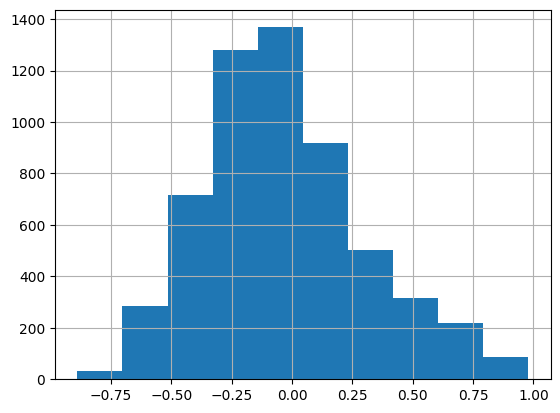

In [6]:
df['score'].hist()

We can see that the scores follow a normal distribution which means that class imbalance would be present for the classification model. We will attempt to remedy that using an undersampling technique based on thresholds.

In [7]:
toxic = df[df['score'] >= 0.5]
wholesome = df[df['score'] <= -0.45]
neutral = df[df['score'].between(-0.042, 0.042)]
frames = [toxic, wholesome, neutral]
df = pd.concat(frames)

In [8]:
df['label'] = None
for i in range(len(df)):
    if df['score'].iloc[i] >= 0.5:
        df['label'].iloc[i] = 'Toxic'
    if df['score'].iloc[i] <= -0.45:
        df['label'].iloc[i] = 'Wholesome'
    if -0.042 <= df['score'].iloc[i] <= 0.042:
        df['label'].iloc[i] = 'Neutral'

C:\Users\Aeriu\AppData\Local\Temp\ipykernel_4028\1334820326.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'].iloc[i] = 'Toxic'
C:\Users\Aeriu\AppData\Local\Temp\ipykernel_4028\1334820326.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'].iloc[i] = 'Wholesome'
C:\Users\Aeriu\AppData\Local\Temp\ipykernel_4028\1334820326.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'].iloc[i] = 'Neutral'


<Axes: >

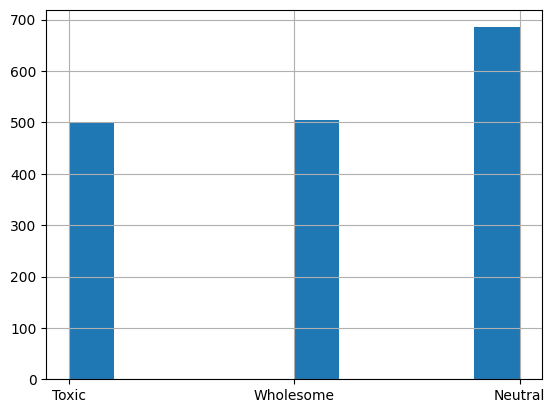

In [9]:
df['label'].hist()

After assigning the labels with the threshold logic the class imbalance has decreased. We can use this variable as the target.

C:\Users\Aeriu\AppData\Local\Temp\ipykernel_4028\2587336479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bodyLength'].iloc[i] = len(df['body'].iloc[i])


<Axes: >

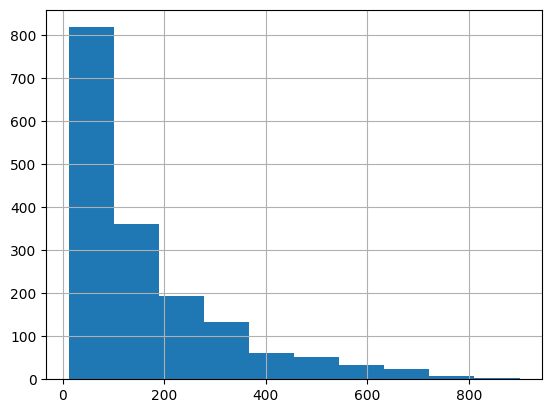

In [10]:
# Checking the lengths of the strings before padding
df['bodyLength'] = None
for i in range(len(df)):
    df['bodyLength'].iloc[i] = len(df['body'].iloc[i])

df['bodyLength'].hist()

We can visually see that the vast majority of comments have lengths around 200 or 400 which means the majority of comments will be padded to the max length parameter in the tokenization process.

In [11]:
# Creating wordcloud of most common words for toxic and wholesome comments
dfToxic = df['body'][df['label'] == 'Toxic']
dfWholesome = df['body'][df['label'] == 'Wholesome']
stopwords = set(STOPWORDS)
valToxic = str(dfToxic)
valWholesome = str(dfWholesome)

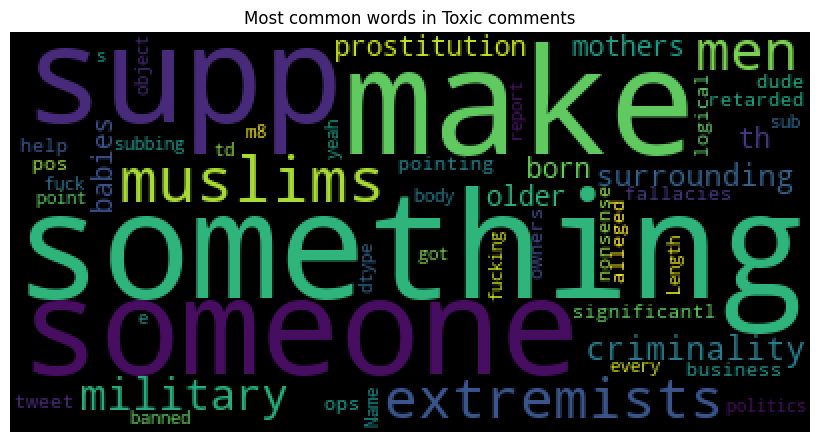

In [12]:
wordCloudToxic = WordCloud(stopwords = STOPWORDS).generate(valToxic)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordCloudToxic)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Most common words in Toxic comments')
plt.show()

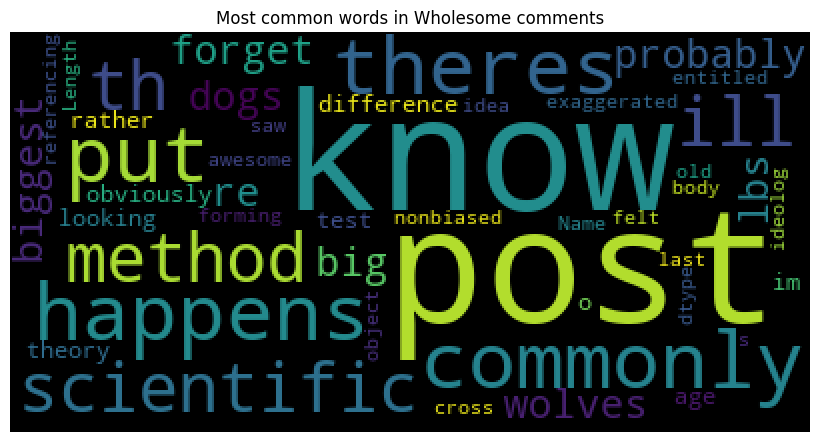

In [13]:
wordCloudWholesome = WordCloud(stopwords = STOPWORDS).generate(valWholesome)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordCloudWholesome)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Most common words in Wholesome comments')
plt.show()

## NLP + ML

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [15]:
# We can see that the tokenizer is returning tensors and the input_ids can be converted to tokens
example = tokenizer(df['body'].iloc[0])
tokens = tokenizer.convert_ids_to_tokens(example['input_ids'])
tokenIds = example
text = df['body'].iloc[0]

print(f'Text: {text}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {tokenIds}')

Text: if something like this could make someone support isis then they were barbaric savages already lost causes
Tokens: ['[CLS]', 'if', 'something', 'like', 'this', 'could', 'make', 'someone', 'support', 'isis', 'then', 'they', 'were', 'bar', '##bari', '##c', 'savage', '##s', 'already', 'lost', 'causes', '[SEP]']
Token IDs: {'input_ids': [101, 2065, 2242, 2066, 2023, 2071, 2191, 2619, 2490, 18301, 2059, 2027, 2020, 3347, 25990, 2278, 9576, 2015, 2525, 2439, 5320, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


We can see the Bert tokenizer's greedy algorithm at work where it's trying to tokenize words by delimiter and then when it can't it tokenizes based on paritions of that word. In the example above, the tokenizer doesn't recognize the word 'barbaric' and thus splits the word and prefixes the latter paritions: 'bar', ##bari' and '##c'. The token ID's reference the index position/key in the token list.

In [16]:
# Train Test Split
train_df = df.sample(frac = 0.8, random_state = 42)
test_df = df.drop(train_df.index).sample(frac = 1.0, random_state = 42)

In [17]:
def BertEncoder(input_text):
    input_ids = []
    attention_masks = []
    for text in input_text:
        output_dict = tokenizer.encode_plus(
            text, 
            add_special_tokens = True,
            truncation = True,
            max_length = 512,
            padding = 'max_length'
        )
        input_ids.append(output_dict['input_ids'])
        attention_masks.append(output_dict['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

This is the encoder that we will use to convert the 'body' variable into formatted features that will be used as input in the model.

In [18]:
#  encoding label and splitting id's and attention mask's from strings
enc = OneHotEncoder(handle_unknown = 'ignore')
text = train_df['body']
df_target = enc.fit_transform(df[['label']]).toarray()
target = enc.fit_transform(train_df[['label']]).toarray()
train_input_ids, train_attention_masks = BertEncoder(text)

In [19]:
# Creating a dictionary index:label that we will use to decode when predicting
df['encode'] = [array for array in df_target]

lst = []
keys = []
values = []
for i in range(len(df)):
    if np.argmax(df['encode'].iloc[i]) not in lst:
        lst.append(np.argmax(df['encode'].iloc[i]))
        keys.append(np.argmax(df['encode'].iloc[i]))
        values.append(df['label'].iloc[i])

decodeDict = dict(zip(keys, values))

In [20]:
decodeDict

{1: 'Toxic', 2: 'Wholesome', 0: 'Neutral'}

We now have a dictionary that can decode th OHE'd target back to the original string labels.

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

Low learning rates generally work best in neural networks. We use Adam and categoricalCrossentropy as these are the gold standards for multi-class classification neural networks.

In [22]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

input_ids = tf.keras.Input(shape = (512,), dtype = 'int32')
attention_masks = tf.keras.Input(shape = (512,), dtype = 'int32')

output = bert_model([input_ids, attention_masks])
output = output[1]
output = tf.keras.layers.Dense(32, activation = 'relu')(output)
output = tf.keras.layers.Dropout(0.2)(output)
output = tf.keras.layers.Dense(3, activation = 'softmax')(output)

model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
model.compile(optimizer = optimizer,
              loss = loss,
              metrics = [acc])

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


We're using 512 for shape as that is the max length of the padded strings converted to input id's and attention masks. In the neural network layers we are using a dropout layer which is a technique that helps prevent overfitting the training data as Neural Networks are prone to doing so after multiple epochs. 'relu' and 'softmax' are standard for multi-class classification parameters in Keras NN. We compile the model here and then train it in the next block.

In [23]:
# checkpoint_filepath = path + '\\Desktop\\Final\\model'

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath = checkpoint_filepath,
#     save_freq = 'epoch',
#     monitor = 'val_accuracy',
#     mode = 'max',
#     save_best_only = True)

# hist = model.fit(
#     [train_input_ids, train_attention_masks],
#     target, 
#     validation_split = 0.2,
#     epochs = 10,
#     batch_size = 10,
#     callbacks = [model_checkpoint_callback],
#     verbose = True
# )

# Epoch 1/10
# 109/109 [==============================] - ETA: 0s - loss: 0.9860 - accuracy: 0.5148 
# WARNING:absl:Found untraced functions such as embeddings_layer_call_fn, embeddings_layer_call_and_return_conditional_losses, encoder_layer_call_fn, encoder_layer_call_and_return_conditional_losses, pooler_layer_call_fn while saving (showing 5 of 420). These functions will not be directly callable after loading.
# INFO:tensorflow:Assets written to: C:\Users\Aeriu\Desktop\Final\model\assets
# INFO:tensorflow:Assets written to: C:\Users\Aeriu\Desktop\Final\model\assets
# 109/109 [==============================] - 1244s 11s/step - loss: 0.9860 - accuracy: 0.5148 - val_loss: 0.8274 - val_accuracy: 0.6728
# Epoch 2/10
# 109/109 [==============================] - ETA: 0s - loss: 0.6374 - accuracy: 0.7482 
# WARNING:absl:Found untraced functions such as embeddings_layer_call_fn, embeddings_layer_call_and_return_conditional_losses, encoder_layer_call_fn, encoder_layer_call_and_return_conditional_losses, pooler_layer_call_fn while saving (showing 5 of 420). These functions will not be directly callable after loading.
# INFO:tensorflow:Assets written to: C:\Users\Aeriu\Desktop\Final\model\assets
# INFO:tensorflow:Assets written to: C:\Users\Aeriu\Desktop\Final\model\assets
# 109/109 [==============================] - 1273s 12s/step - loss: 0.6374 - accuracy: 0.7482 - val_loss: 0.4994 - val_accuracy: 0.7978
# Epoch 3/10
# 109/109 [==============================] - ETA: 0s - loss: 0.2898 - accuracy: 0.9151 
# WARNING:absl:Found untraced functions such as embeddings_layer_call_fn, embeddings_layer_call_and_return_conditional_losses, encoder_layer_call_fn, encoder_layer_call_and_return_conditional_losses, pooler_layer_call_fn while saving (showing 5 of 420). These functions will not be directly callable after loading.
# INFO:tensorflow:Assets written to: C:\Users\Aeriu\Desktop\Final\model\assets
# INFO:tensorflow:Assets written to: C:\Users\Aeriu\Desktop\Final\model\assets
# 109/109 [==============================] - 1363s 12s/step - loss: 0.2898 - accuracy: 0.9151 - val_loss: 0.3432 - val_accuracy: 0.8860
# Epoch 4/10
# 109/109 [==============================] - ETA: 0s - loss: 0.1529 - accuracy: 0.9668 
# WARNING:absl:Found untraced functions such as embeddings_layer_call_fn, embeddings_layer_call_and_return_conditional_losses, encoder_layer_call_fn, encoder_layer_call_and_return_conditional_losses, pooler_layer_call_fn while saving (showing 5 of 420). These functions will not be directly callable after loading.
# INFO:tensorflow:Assets written to: C:\Users\Aeriu\Desktop\Final\model\assets
# INFO:tensorflow:Assets written to: C:\Users\Aeriu\Desktop\Final\model\assets
# 109/109 [==============================] - 1425s 13s/step - loss: 0.1529 - accuracy: 0.9668 - val_loss: 0.3611 - val_accuracy: 0.8934
# Epoch 5/10
# 109/109 [==============================] - 1405s 13s/step - loss: 0.1088 - accuracy: 0.9751 - val_loss: 0.5201 - val_accuracy: 0.8603
# Epoch 6/10
# 109/109 [==============================] - 1371s 13s/step - loss: 0.0565 - accuracy: 0.9880 - val_loss: 0.3957 - val_accuracy: 0.8897
# Epoch 7/10
# 109/109 [==============================] - 1376s 13s/step - loss: 0.0318 - accuracy: 0.9954 - val_loss: 0.4836 - val_accuracy: 0.8897
# Epoch 8/10
# 109/109 [==============================] - 1401s 13s/step - loss: 0.0299 - accuracy: 0.9926 - val_loss: 0.5332 - val_accuracy: 0.8787
# Epoch 9/10
# 109/109 [==============================] - 1387s 13s/step - loss: 0.0157 - accuracy: 0.9991 - val_loss: 0.8137 - val_accuracy: 0.8235
# Epoch 10/10
# 109/109 [==============================] - 1382s 13s/step - loss: 0.0211 - accuracy: 0.9972 - val_loss: 0.6433 - val_accuracy: 0.8787

Validation accuracy is generally a better metric than training accuracy as it leads to better out-of-sample generalization for the model in the long run. If the new epoch's validation accuracy is higher than the last then the model saves that epoch as a checkpoint.

In [24]:
# Saving model
#model.save('reddit_model')
#model.save('reddit_model_h5', save_format = 'h5')

Saving the model which will be loaded in within the Flask app.

In [25]:
# # Saving history for analytics
# hist_csv_file = 'history.csv'
# hist_df = pd.DataFrame(hist.history) 
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

Saving the history file from the model training for post-training analytics.

In [26]:
# Importing saved model
model = tf.keras.models.load_model('reddit_model_h5', custom_objects = {'TFBertModel': transformers.TFBertModel})

## Post-Training Analysis

In [27]:
# Importing Keras neural network training history
hist_df = pd.read_csv('history.csv')
hist_df.rename(columns = {'Unnamed: 0': 'epoch'}, inplace = True)
hist_df['epoch'] = hist_df['epoch'] + 1
hist_df.index += 1

In [28]:
hist_df

,epoch,loss,accuracy,val_loss,val_accuracy
1,1,0.986033,0.514760,0.827361,0.672794
2,2,0.637396,0.748155,0.499441,0.797794
3,3,0.289775,0.915129,0.343159,0.886029
4,4,0.152917,0.966790,0.361142,0.893382
5,5,0.108828,0.975092,0.520081,0.860294
6,6,0.056534,0.988007,0.395662,0.889706
7,7,0.031827,0.995387,0.483637,0.889706
8,8,0.029891,0.992620,0.533235,0.878676
9,9,0.015680,0.999077,0.813690,0.823529
10,10,0.021136,0.997232,0.643294,0.878676


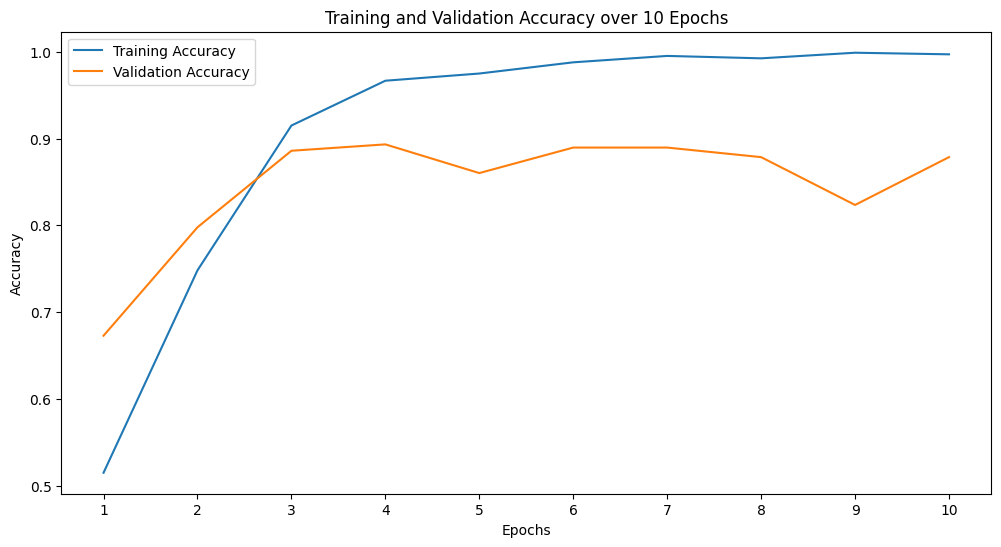

In [29]:
# Plotting neural network training history
figure(figsize=(12, 6))
plt.title('Training and Validation Accuracy over 10 Epochs')
plt.plot(hist_df['accuracy'], label = 'Training Accuracy')
plt.plot(hist_df['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(hist_df['epoch'])
plt.show()

In [30]:
hist_df[hist_df['val_accuracy'] == hist_df['val_accuracy'].max()]

,epoch,loss,accuracy,val_loss,val_accuracy
4,4,0.152917,0.96679,0.361142,0.893382


We can see that the model chose epoch 4 as the epoch with the optimal weightings as it has the highest validation accuracy.

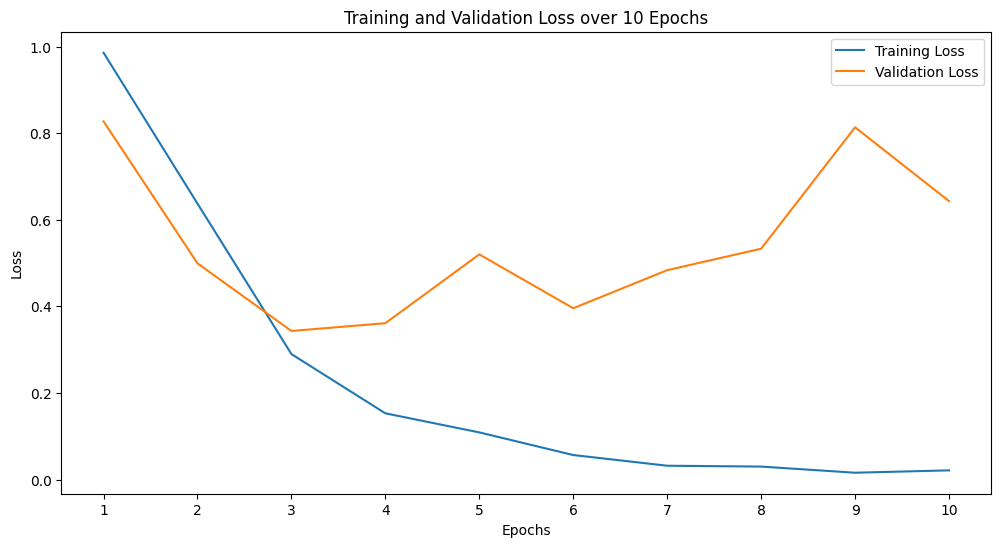

In [31]:
# Training and Validation Loss
figure(figsize=(12, 6))
plt.title('Training and Validation Loss over 10 Epochs')
plt.plot(hist_df['loss'], label = 'Training Loss')
plt.plot(hist_df['val_loss'], label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(hist_df['epoch'])
plt.show()

In [32]:
hist_df['val_loss'].sort_values()

3     0.343159
4     0.361142
6     0.395662
7     0.483637
2     0.499441
5     0.520081
8     0.533235
10    0.643294
9     0.813690
1     0.827361
Name: val_loss, dtype: float64

Epoch 3 actually has lower validation loss than epoch 4 but because we want the highest validation accuracy epoch 4 will be used. However, epoch 3 has a smaller sum of errors which means the model is a bit more confident on its predictions here despite having lower validation accuracy.

In [33]:
# Creating Pipeline that will be used to take in the input df column, clean it, convert to input ids and attention masks, predict, and then convert decode the arrays
def TestPipeline(df, col):
    df = df[~df['body'].isin(['removed', '[removed]', 'deleted', '[deleted]'])]

    df['predicted_label'] = None
    df[col] = df[col].map(cleaner)
    y_hat = model.predict(BertEncoder(df[col]))
    for i in range(len(df)):
        df['predicted_label'].iloc[i] = decodeDict[np.argmax(y_hat[i])]
    
    return df

Creating a test prediction function which will be used to evaluate the test set

In [34]:
# Predicting test data
test_df = TestPipeline(test_df, 'body')
accuracy = round(accuracy_score(test_df['label'], test_df['predicted_label']) * 100, 2)
print(f'Test Accuracy: {accuracy}%')

11/11 [==============================] - 148s 13s/step
Test Accuracy: 92.9%


C:\Users\Aeriu\AppData\Local\Temp\ipykernel_4028\1195039601.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_label'].iloc[i] = decodeDict[np.argmax(y_hat[i])]


We can see that both the test accuracy is about 93%

In [35]:
# Taking a look at the incorrect predictions
falsePred = test_df[test_df['label'] != test_df['predicted_label']]
falsePred

,comment_id,body,score,label,bodyLength,predicted_label
2074,d0b7y6c,i love the life and times of the thunderbolt k...,-0.521,Wholesome,431,Neutral
4468,e6bsb5s,dude enjoy your last moments you have a 95 cha...,0.604,Toxic,198,Neutral
3510,e344ib6,he just starts running away,-0.500,Wholesome,27,Neutral
4526,eea91jh,we should vibrate all kids,0.021,Neutral,26,Wholesome
5764,eeqfjly,if that isn’t the pot calling the kettle black,-0.021,Neutral,46,Wholesome
2507,ew8q7v5,yeah but what if it’s that person’s day off an...,-0.458,Wholesome,85,Neutral
3299,dsck0wm,thorin doesnt know anything about cs other tha...,0.021,Neutral,70,Wholesome
3357,dtxf37d,there are times and places where its ok for a ...,0.511,Toxic,100,Neutral
4670,ejjxnyh,enough hiding fire up the annihilator gene,-0.042,Neutral,42,Wholesome
2136,d8qo4e7,george on greys anatomy absolutely broke my heart,-0.532,Wholesome,49,Neutral


In [36]:
report = classification_report(test_df['label'], test_df['predicted_label'], output_dict = True)
reportDf = pd.DataFrame.from_dict(report).transpose()
reportDf

,precision,recall,f1-score,support
Neutral,0.906832,0.941935,0.924051,155.000000
Toxic,0.976744,0.933333,0.954545,90.000000
Wholesome,0.923077,0.903226,0.913043,93.000000
accuracy,0.928994,0.928994,0.928994,0.928994
macro avg,0.935551,0.926165,0.930547,338.000000
weighted avg,0.929918,0.928994,0.929142,338.000000


We can see that the 'Toxic' label has the highest precision at 98% meaning 98% of predictions for this label are correct.
'Neutral' has the highest recall which means 94% of predictions for this label are correct out of the total number of true 'Neutral' labels.
The F1 score (harmonic mean) is skewed by class imbalance which isn't heavily prevalent due to the fact that the labels were undersampled to ensure class balance so the F1 score is very close to the test accuracy.

## Reddit Comment Scraping

In [37]:
# Creating full pipeline that will scrape a user's reddit comments, convert to df, predict, and then compute and return metrics
def load_model():
    model = tf.keras.models.load_model('reddit_model_h5', custom_objects = {'TFBertModel': transformers.TFBertModel})
    
def load_pmaw():
    from pmaw import PushshiftAPI
    global api
    api = PushshiftAPI()

def Output(commentDf, username):
    maxLabel = commentDf['label'].max()
    maxLabelCount = len(commentDf[commentDf['label'] == maxLabel])
    totalComments = len(commentDf)
    maxLabelPercent = round(maxLabelCount / totalComments, 2) * 100
    samples = commentDf[commentDf['label'] == maxLabel].sample(5)
    
    print(f'The user {username} is mostly {maxLabel}')
    print(f'{maxLabelPercent}% of {username}"s comments are {maxLabel}')
    print(f'In total {maxLabelCount} of {totalComments} comments are {maxLabel}')
        
def Predict(text):
    # Get user input for username and scrape comments
    if text == '':
        return print('You must enter a valid username')
    username = str(text)
    r = requests.get(f'https://api.pushshift.io/reddit/search/comment?author={username}&size=50&metadata=false&fields=body')
    j = r.json()
    comments = []
    for i in range(len(j['data'])):
        comments.append((j['data'][i]['body']))
    if len(comments) == 0:
        return print('No comments found for this user')
    # create dataframe 
    df = pd.DataFrame(comments)
    df.rename(columns = {0: 'body'}, inplace = True)
    # clean df
    df = df[~df['body'].isin(['removed', '[removed]', 'deleted', '[deleted]'])]
    df['body'] = df['body'].map(cleaner)
    df['label'] = None
    # creating new column and predicting
    y_hat = model.predict(BertEncoder(df['body']))
    for i in range(len(df)):
        df['label'].iloc[i] = decodeDict[np.argmax(y_hat[i])]
        
    # Counting and aggregation logic
    wholesomeCount = 0
    neutralCount = 0
    toxicCount = 0
    
    for i in range(len(df)):
        if df['label'].iloc[i] == 'Wholesome':
            wholesomeCount += 1
        if df['label'].iloc[i] == 'Neutral':
            neutralCount += 1
        if df['label'].iloc[i] == 'Toxic':
            toxicCount += 1   
    
    dic = {'Wholesome': wholesomeCount, 'Neutral': neutralCount, 'Toxic': toxicCount}
    sortedDic = sorted(dic.items(), key = lambda t: t[1])
    
    maxLabelCount = sortedDic[2][1]
    medLabelCount = sortedDic[1][1]
    lowLabelCount = sortedDic[0][1]
    
    maxLabel = sortedDic[2][0]
    medLabel = sortedDic[1][0]
    lowLabel = sortedDic[0][0]
    
    totalComments = len(df)
    maxLabelPercent = round(round(maxLabelCount / totalComments, 2) * 100)
    medLabelPercent = round(round(medLabelCount / totalComments, 2) * 100)
    lowLabelPercent = round(round(lowLabelCount / totalComments, 2) * 100)
    
    return print(f'''The user {username} is mostly {maxLabel}.
    In total {maxLabelCount} of {totalComments} comments are {maxLabel} ({maxLabelPercent}%),
    {medLabelCount} of {totalComments} are {medLabel} ({medLabelPercent}%),
    and {lowLabelCount} of {totalComments} are {lowLabel} ({lowLabelPercent}%).''')

In [38]:
# Test
Predict('dbearborg')

2/2 [==============================] - 20s 7s/step
The user dbearborg is mostly Neutral.
    In total 31 of 50 comments are Neutral (62%),
    10 of 50 are Wholesome (20%),
    and 9 of 50 are Toxic (18%).


## Flask App

In [39]:
from flask import Flask, render_template, request
import requests
import pandas as pd
import numpy as np
from tensorflow import keras
from transformers import BertTokenizer
import tensorflow as tf
import transformers
import threading
import re
from string import punctuation
import os

#path = os.getcwd() + '\\reddit_model_h5'

model = tf.keras.models.load_model('reddit_model_h5', custom_objects = {'TFBertModel': transformers.TFBertModel})
    
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def BertEncoder(input_text):
    input_ids = []
    attention_masks = []
    for text in input_text:
        output_dict = tokenizer.encode_plus(
            text, 
            add_special_tokens = True,
            truncation = True,
            max_length = 512,
            padding = 'max_length'
        )
        input_ids.append(output_dict['input_ids'])
        attention_masks.append(output_dict['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

def Output(commentDf, username):
    maxLabel = commentDf['label'].mode()
    maxLabelCount = len(commentDf[commentDf['label'] == maxLabel])
    totalComments = len(commentDf)
    maxLabelPercent = round(maxLabelCount / totalComments, 2) * 100
    
    print(f'The user {username} is mostly {maxLabel}')
    print(f'{maxLabelPercent}% of {username}"s comments are {maxLabel}')
    print(f'In total {maxLabelCount} of {totalComments} comments are {maxLabel}')

def cleaner(txt):
    txt = txt.lower()
    txt = txt.replace('\n', ' ')
    txt = re.sub(f'[{re.escape(punctuation)}]', '', txt)
    txt = ' '.join(txt.split())
    txt = txt.strip()
    return txt

decodeDict = {1: 'Toxic', 2: 'Wholesome', 0: 'Neutral'}

def Predict(text):
    # Get user input for username and scrape comments
    if text == '':
        return print('You must enter a valid username')
    username = str(text)
    r = requests.get(f'https://api.pushshift.io/reddit/search/comment?author={username}&size=50&metadata=false&fields=body')
    j = r.json()
    comments = []
    for i in range(len(j['data'])):
        comments.append((j['data'][i]['body']))
    if len(comments) == 0:
        return print('No comments found for this user')
    # create dataframe 
    df = pd.DataFrame(comments)
    df.rename(columns = {0: 'body'}, inplace = True)
    # clean df
    df = df[~df['body'].isin(['removed', '[removed]', 'deleted', '[deleted]'])]
    df['body'] = df['body'].map(cleaner)
    df['label'] = None
    # creating new column and predicting
    y_hat = model.predict(BertEncoder(df['body']))
    for i in range(len(df)):
        df['label'].iloc[i] = decodeDict[np.argmax(y_hat[i])]
        
    # Counting and aggregation logic
    wholesomeCount = 0
    neutralCount = 0
    toxicCount = 0
    
    for i in range(len(df)):
        if df['label'].iloc[i] == 'Wholesome':
            wholesomeCount += 1
        if df['label'].iloc[i] == 'Neutral':
            neutralCount += 1
        if df['label'].iloc[i] == 'Toxic':
            toxicCount += 1   
    
    dic = {'Wholesome': wholesomeCount, 'Neutral': neutralCount, 'Toxic': toxicCount}
    sortedDic = sorted(dic.items(), key = lambda t: t[1])
    
    maxLabelCount = sortedDic[2][1]
    medLabelCount = sortedDic[1][1]
    lowLabelCount = sortedDic[0][1]
    
    maxLabel = sortedDic[2][0]
    medLabel = sortedDic[1][0]
    lowLabel = sortedDic[0][0]
    
    totalComments = len(df)
    maxLabelPercent = round(round(maxLabelCount / totalComments, 2) * 100)
    medLabelPercent = round(round(medLabelCount / totalComments, 2) * 100)
    lowLabelPercent = round(round(lowLabelCount / totalComments, 2) * 100)
    
    return f'''The user {username} is mostly {maxLabel}.
    In total {maxLabelCount} of {totalComments} comments are {maxLabel} ({maxLabelPercent}%),
    {medLabelCount} of {totalComments} are {medLabel} ({medLabelPercent}%),
    and {lowLabelCount} of {totalComments} are {lowLabel} ({lowLabelPercent}%).'''

app = Flask(__name__)

@app.route('/', methods = ['GET'])
def render():
    return render_template('index.html')

@app.route('/', methods = ['POST'])
def main():
    author = request.form['u']
    return Predict(author)


#if __name__ == '__main__':
#    app.run(host = '0.0.0.0', port = int(3000), debug = True)

## Index HTML file

Index

<!DOCTYPE html>
<html>
    <head>
        <title> Reddit User Sentiment Analysis</title>
    </head>

    <body>
        <h1>Reddit User Sentiment Analysis</h1>
        <form method="POST">
            <input name="u">
            <input type="submit">
        </form>
    </body>
</html>

## URL

In [41]:
print('URL: https://mlapp-wzl3auzckq-uc.a.run.app/')
print ('Notice: It takes a long time to both load the website and run the sentiment analysis')
print ("Notice 2: Depending on when this URL is visited there's a chance my GCP free trial has expired rendering the URL dead")

URL: https://mlapp-wzl3auzckq-uc.a.run.app/
Notice: It takes a long time to both load the website and run the sentiment analysis
Notice 2: Depending on when this URL is visited there's a chance my GCP free trial has expired rendering the URL dead
